# 

**FTEC5530 Project 1**

Name: Man Yat Fu SID:1155109353

- [x] Fetch Data
- [x] Function of MA and EMA
- [x] Function of Buy and hold result
- [x] Function of Win Ratio
- [x] Function of Max win/loss percentage
- [x] Function of Choosing different parameter
- [x] Propose a set of suitable parameters, analysis the reason
- [x] Analysis and comparison between EMA and MACD signal performance
- [x] Chart 1 Data Information (Describe CCXT Data)
- [x] Chart 2 Measurement of common parameter in the market MACD
- [x] Chart 3 Measurement of common parameter in the market EMA
- [x] Chart 4 Optimized Parameter for MACD
- [x] Chart 5 Optimized Parameter for EMA
- [x] Chart 6 Buy and Hold 






In [ ]:
import ta
import ccxt
import copy
import time
import schedule
import operator
import numpy as np
import pandas as pd
from ta.utils import dropna
from functools import reduce
from datetime import datetime
import matplotlib.pyplot as plt
from ta.trend import macd, macd_diff,macd_signal

#Configuration 

pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)

import warnings
warnings.filterwarnings('ignore')

# Pi operator for product of all elements
def prod(iterable):
    return reduce(operator.mul, iterable, 1)


We define a function to get the bar from one currency to another.
We get at most 2000 data each time due to the exchange's transmision length limitation.

In [ ]:
def get_bar_from_to(ex, symbol, period, start_time, end_time, length=2000, maxLoop=20):
    data = []
    stime = ex.parse8601(start_time)
    etime = ex.parse8601(end_time)
    loop_i = 0
    if ex.has['fetchOHLCV']:
        while stime < etime and loop_i < maxLoop:
            loop_i += 1
            try:
                ohlcvs = ex.fetch_ohlcv(symbol, period, stime, limit=length)
                if len(ohlcvs) > 1:
                    first = ohlcvs[0][0]
                    last = ohlcvs[-1][0]
                    stime = int(last + (last - first) / (len(ohlcvs) - 1))
                    data += ohlcvs
                    time.sleep(1)
                else:
                    return data
            except Exception as e:
                continue
    return data

Fetch Data From CCXT

In [3]:
# Set the exchange - binance
exchange = ccxt.binance()

# Download daily data of 'BTC/USDT'
daily_BTC = get_bar_from_to(exchange, 'BTC/USDT', '1d', start_time='2017-08-17 00:00:00', end_time='2022-03-04 23:59:59')
daily_BTC = pd.DataFrame(daily_BTC, columns=['time','open','high','low','close','volume']) # ohlcv is open, high, low, close, volume
daily_BTC = daily_BTC[daily_BTC['time'] < exchange.parse8601('2022-02-05 23:00:00')] # convert the time format
daily_BTC['time'] = daily_BTC['time'].apply(lambda x: exchange.iso8601(x)[:10])

# Download hourly data of 'BTC/USDT'
hourly_BTC = get_bar_from_to(exchange, 'BTC/USDT', '1h', '2021-01-01 00:00:00', '2022-03-04 23:59:59')
hourly_BTC = pd.DataFrame(hourly_BTC, columns=['time','open','high','low','close','volume'])
hourly_BTC = hourly_BTC[hourly_BTC['time'] < exchange.parse8601('2022-02-05 23:59:59')]
hourly_BTC['time'] = hourly_BTC['time'].apply(lambda x: exchange.iso8601(x)[:13])

# Download daily data of 'ETH/USDT'
daily_ETH = get_bar_from_to(exchange, 'ETH/USDT', '1d', '2017-08-17 00:00:00', '2022-03-04 23:59:59')
daily_ETH = pd.DataFrame(daily_ETH, columns=['time','open','high','low','close','volume'])
daily_ETH = daily_ETH[daily_ETH['time'] < exchange.parse8601('2022-02-05 23:00:00')]
daily_ETH['time'] = daily_ETH['time'].apply(lambda x: exchange.iso8601(x)[:10])

# Download hourly data of 'ETH/USDT'
hourly_ETH = get_bar_from_to(exchange, 'ETH/USDT', '1h', '2021-01-01 00:00:00', '2022-03-04 23:59:59')
hourly_ETH = pd.DataFrame(hourly_ETH, columns=['time','open','high','low','close','volume'])
hourly_ETH = hourly_ETH[hourly_ETH['time'] < exchange.parse8601('2022-02-05 23:59:59')]
hourly_ETH['time'] = hourly_ETH['time'].apply(lambda x: exchange.iso8601(x)[:13])




MACD

In [4]:
def MACD_Strategy(df):
    MACD_Buy=[]
    MACD_Sell=[]
    winRateList = []
    position=False

    for i in range(0, len(df)):
        if df['macd'][i] > df['macd_signal'][i] :
            MACD_Sell.append(np.nan)
            if position ==False:
                MACD_Buy.append(df['close'][i])
                position=True
            else:
                MACD_Buy.append(np.nan)
        elif df['macd'][i] < df['macd_signal'][i] :
            MACD_Buy.append(np.nan)
            if position == True:
                MACD_Sell.append(df['close'][i])
                position=False
            else:
                MACD_Sell.append(np.nan)
        elif position == True and df['close'][i] < MACD_Buy[-1]:
            MACD_Sell.append(df["close"][i])
            MACD_Buy.append(np.nan)
            position = False
        elif position == True and df['close'][i] < df['close'][i - 1]:
            MACD_Sell.append(df["close"][i])
            MACD_Buy.append(np.nan)
            position = False
        else:
            MACD_Buy.append(np.nan)
            MACD_Sell.append(np.nan)

    df['MACD_Buy_Signal_price'] = MACD_Buy
    df['MACD_Sell_Signal_price'] = MACD_Sell
    

    cleaned_MACD_Buy = [x for x in MACD_Buy if x > 0]
    cleaned_MACD_Sell = [x for x in MACD_Sell if x > 0]

    if(len(cleaned_MACD_Buy) > len(cleaned_MACD_Sell)):
        cleaned_MACD_Buy.pop()
    if(len(cleaned_MACD_Buy) < len(cleaned_MACD_Sell)):
        cleaned_MACD_Sell.pop()
    for i in range(0,len(cleaned_MACD_Buy)-1):
        for j in range(0,len(cleaned_MACD_Sell)-1):
            if i == j:
                result = (cleaned_MACD_Sell[j] - cleaned_MACD_Buy[i])/cleaned_MACD_Buy[i]
                winRateList.append(result)
                
    pos = [x for x in winRateList if x > 0]
    winRatio = len(pos)/len(winRateList)
    AvgReturn = sum(winRateList) / len(winRateList)
    PrinciplewinRateList = [x+1 for x in winRateList] #add 1 to winRateList and consider accumulated return
    ACReturn = prod(PrinciplewinRateList)-1
    return df,max(winRateList),min(winRateList),winRatio,ACReturn,AvgReturn


#This function will run as least 1 hour for daily dataframe, 3 hours for hour dataframe
def optimizedPara(df,startFast=1):
    ACReturn = 0
    maxFast = 0
    maxSign = 0
    maxSlow = 0
    winRatio = 0
    AvgReturn = 0
    maxLoss = 1000
    for fast in range(startFast,98):
        for sign in range(2,99):
            if(fast<sign):
                for slow in range(3,100):
                    if (sign<slow):    
                        df['macd'] = ta.trend.macd(df['close'],window_fast = fast,window_slow = slow)
                        df['macd_signal'] = ta.trend.macd_signal(df['close'],window_fast = fast,window_slow = slow,window_sign=sign)
                        df,maxwin,maxloss,winratio,acReturn,Avgreturn = MACD_Strategy(df)
                        if(acReturn > ACReturn):
                            ACReturn = acReturn
                            maxFast = fast
                            maxSign = sign
                            maxSlow = slow
                            winRatio = winratio
                            AvgReturn = Avgreturn
                            maxLoss = maxloss
                            maxWin = maxwin
                            print(maxFast,maxSign,maxSlow)
                        
    return ACReturn,maxWin,maxLoss,winRatio,AvgReturn,maxFast,maxSign,maxSlow


def displayResult(df):
    ACReturn,maxWin,maxLoss,winRatio,AvgReturn,maxFast,maxSign,maxSlow = optimizedPara(df)
    print("The Accumulated return is " + str(ACReturn))
    print("The Max Win is " + str(maxWin))
    print("The Max Loss return is " + str(maxLoss))
    print("The Win Ratio return is " + str(winRatio))
    print("The Average Return return is " + str(AvgReturn))
    print("The fast-Parameter is " + str(maxFast))
    print("The sign-Parameter is " + str(maxSign))
    print("The slow-Parameter is " + str(maxSlow))



# daily_BTC,winRateList,maxWin,maxLoss,winRatio,ACReturn,AvgReturn = MACD_Strategy(daily_BTC)



In [5]:
#  df,max(winRateList),min(winRateList),winRatio,ACReturn,AvgReturn

daily_BTC['macd'] = ta.trend.macd(daily_BTC['close'],window_fast = 12,window_slow = 26)
daily_BTC['macd_signal'] = ta.trend.macd_signal(daily_BTC['close'],window_fast = 12,window_slow = 26,window_sign=9)
daily_BTC['macd_diff'] = ta.trend.macd_diff(daily_BTC['close'],window_fast = 12,window_slow = 26,window_sign=9)
print(MACD_Strategy(daily_BTC))

hourly_BTC['macd'] = ta.trend.macd(hourly_BTC['close'],window_fast = 12,window_slow = 26)
hourly_BTC['macd_signal'] = ta.trend.macd_signal(hourly_BTC['close'],window_fast = 12,window_slow = 26,window_sign=9)
hourly_BTC['macd_diff'] = ta.trend.macd_diff(hourly_BTC['close'],window_fast = 12,window_slow = 26,window_sign=9)
print(MACD_Strategy(hourly_BTC))

daily_ETH['macd'] = ta.trend.macd(daily_ETH['close'],window_fast = 12,window_slow = 26)
daily_ETH['macd_signal'] = ta.trend.macd_signal(daily_ETH['close'],window_fast = 12,window_slow = 26,window_sign=9)
daily_ETH['macd_diff'] = ta.trend.macd_diff(daily_ETH['close'],window_fast = 12,window_slow = 26,window_sign=9)
print(MACD_Strategy(daily_ETH))

hourly_ETH['macd'] = ta.trend.macd(hourly_ETH['close'],window_fast = 12,window_slow = 26)
hourly_ETH['macd_signal'] = ta.trend.macd_signal(hourly_ETH['close'],window_fast = 12,window_slow = 26,window_sign=9)
hourly_ETH['macd_diff'] = ta.trend.macd_diff(hourly_ETH['close'],window_fast = 12,window_slow = 26,window_sign=9)
print(MACD_Strategy(hourly_ETH))



(            time      open      high       low     close        volume  \
0     2017-08-17   4261.48   4485.39   4200.74   4285.08    795.150377   
1     2017-08-18   4285.08   4371.52   3938.77   4108.37   1199.888264   
2     2017-08-19   4108.37   4184.69   3850.00   4139.98    381.309763   
3     2017-08-20   4120.98   4211.08   4032.62   4086.29    467.083022   
4     2017-08-21   4069.13   4119.62   3911.79   4016.00    691.743060   
...          ...       ...       ...       ...       ...           ...   
1629  2022-02-01  38466.90  39265.20  38000.00  38694.59  34574.446630   
1630  2022-02-02  38694.59  38855.92  36586.95  36896.36  35794.681300   
1631  2022-02-03  36896.37  37387.00  36250.00  37311.61  32081.109990   
1632  2022-02-04  37311.98  41772.33  37026.73  41574.25  64703.958740   
1633  2022-02-05  41571.70  41913.69  40843.01  41382.59  32532.343720   

             macd  macd_signal   macd_diff  MACD_Buy_Signal_price  \
0             NaN          NaN         Na

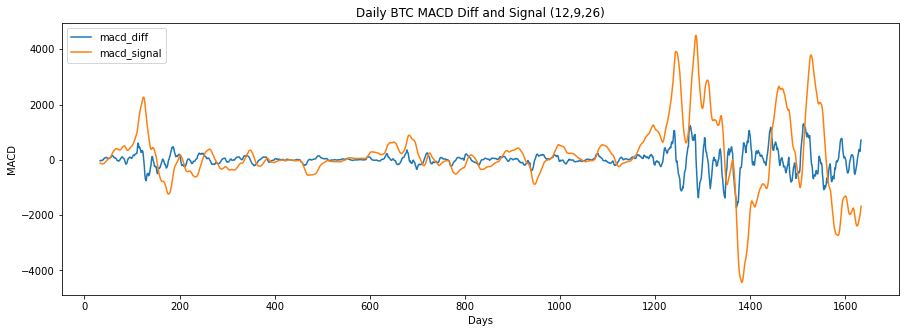

In [6]:
#Example of MACD Graph 12,9,26
daily_BTC['macd'] = ta.trend.macd(daily_BTC['close'],window_fast = 12,window_slow = 26)
daily_BTC['macd_signal'] = ta.trend.macd_signal(daily_BTC['close'],window_fast = 12,window_slow = 26,window_sign=9)
daily_BTC['macd_diff'] = ta.trend.macd_diff(daily_BTC['close'],window_fast = 12,window_slow = 26,window_sign=9)


plt.figure (figsize=(15, 5))
plt.plot(daily_BTC['macd_diff'], label='macd_diff')
plt.plot(daily_BTC['macd_signal'], label='macd_signal')


plt.title ('Daily BTC MACD Diff and Signal (12,9,26)') 
plt.xlabel('Days')
plt.xticks(rotation=0)
plt.ylabel ('MACD') 
plt.legend()
plt.show()

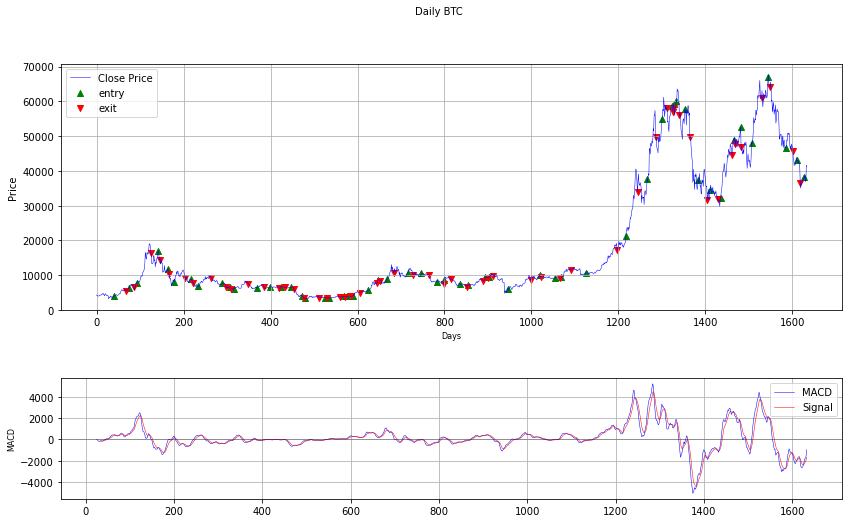

In [7]:
#MACD 12，9，26

data=daily_BTC
plt.rcParams.update({'font.size': 10})
fig, ax1 = plt.subplots(figsize=(14,8))
fig.suptitle("Daily BTC", fontsize=10, backgroundcolor='white', color='black')
ax1 = plt.subplot2grid((14, 8), (0, 0), rowspan=8, colspan=14)
ax2 = plt.subplot2grid((14, 12), (10, 0), rowspan=6, colspan=14)
ax1.set_ylabel('Price')
ax1.plot('close',data=daily_BTC, label='Close Price', linewidth=0.5, color='blue')
ax1.scatter(range(0,len(daily_BTC)), daily_BTC['MACD_Buy_Signal_price'], color='green', marker='^', alpha=1,label='entry')
ax1.scatter(range(0,len(daily_BTC)), daily_BTC['MACD_Sell_Signal_price'], color='red', marker='v', alpha=1,label='exit')
ax1.legend()
ax1.grid()
ax1.set_xlabel('Days', fontsize=8)

ax2.set_ylabel('MACD', fontsize=8)
ax2.plot('macd', data=daily_BTC, label='MACD', linewidth=0.5, color='blue')
ax2.plot('macd_signal', data=daily_BTC, label='Signal', linewidth=0.5, color='red')
ax2.axhline(0, color='black', linewidth=0.5, alpha=0.5)
ax2.legend()
ax2.grid()
plt.show()


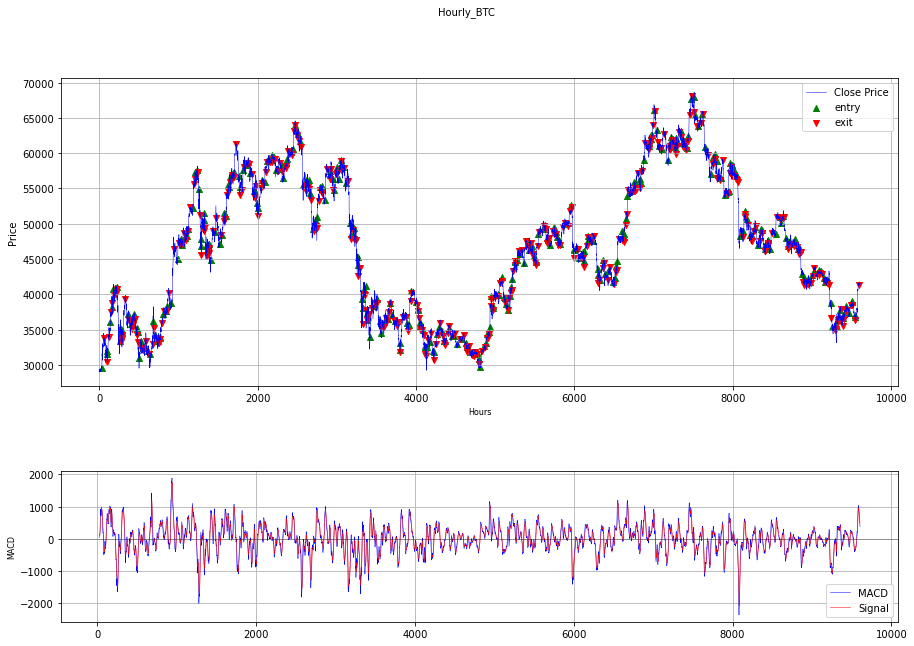

In [14]:
#MACD 12，9，26
hourly_BTC['macd'] = ta.trend.macd(hourly_BTC['close'],window_fast = 12,window_slow = 26)
hourly_BTC['macd_signal'] = ta.trend.macd_signal(hourly_BTC['close'],window_fast = 12,window_slow = 26,window_sign=9)
hourly_BTC['macd_diff'] = ta.trend.macd_diff(hourly_BTC['close'],window_fast = 12,window_slow = 26,window_sign=9)
data=hourly_BTC

plt.rcParams.update({'font.size': 10})
fig, ax1 = plt.subplots(figsize=(15,10))
fig.suptitle("Hourly_BTC", fontsize=10, backgroundcolor='white', color='black')
ax1 = plt.subplot2grid((14, 8), (0, 0), rowspan=8, colspan=14)
ax2 = plt.subplot2grid((14, 12), (10, 0), rowspan=6, colspan=14)
ax1.set_ylabel('Price')
ax1.plot('close',data=hourly_BTC, label='Close Price', linewidth=0.5, color='blue')
ax1.scatter(range(0,len(hourly_BTC)), hourly_BTC['MACD_Buy_Signal_price'], color='green', marker='^', alpha=1,label='entry')
ax1.scatter(range(0,len(hourly_BTC)), hourly_BTC['MACD_Sell_Signal_price'], color='red', marker='v', alpha=1,label='exit')
ax1.legend()
ax1.grid()
ax1.set_xlabel('Hours', fontsize=8)

ax2.set_ylabel('MACD', fontsize=8)
ax2.plot('macd', data=hourly_BTC, label='MACD', linewidth=0.5, color='blue')
ax2.plot('macd_signal', data=hourly_BTC, label='Signal', linewidth=0.5, color='red')
ax2.axhline(0, color='black', linewidth=0.5, alpha=0.5)
ax2.legend()
ax2.grid()
plt.show()


EMA

In [ ]:
def MA(price,days):
    MA = price.transform(lambda x: x.rolling(window = days).mean())
    return MA

def EMA(price, days):
    EMA = price.transform(lambda x: x.ewm(span=days, adjust=False).mean())
    return EMA

def EMA_Strategy(df,shortDays,longDays):
    winRateList = []
    BuyList = []
    SellList = []
    
    df['shortEMA'] = EMA(df['close'],shortDays)
    df['longEMA'] = EMA(df['close'],longDays)
    
    sizeOfDataFrame = len(df)
    signal = 0  #Set 0 first as neutral, 1 buy , -1 sell
    
    for i in range(0,sizeOfDataFrame): 
        if (df['shortEMA'][i] != df['longEMA'][i]):            #Remove the same price cases
            if(df['shortEMA'][i] > 0):                         #Remove NaN value cases
                if(df['longEMA'][i] > 0):
                    if(df['shortEMA'][i] > df['longEMA'][i]):  #buy if shortEMA above longEMA
                        BuyList.append(df['close'][i])
                        if(signal == -1):                               #clean SellList
                            winrate = (len(SellList) * df['close'][i] - sum(SellList)) / sum(SellList)
                            winRateList.append(winrate)
                            SellList.clear()
                        signal = 1
                    else:
                        SellList.append(df['close'][i])        #sell if shortEMA below longEMA
                        if(signal == 1):                               #clean BuyList
                            winrate = (len(BuyList) * df['close'][i] - sum(BuyList)) / sum(BuyList)
                            winRateList.append(winrate)
                            BuyList.clear()
                        signal = -1
    
#     print(winRateList)
    winRatio = len([x for x in winRateList if x > 0]) / len(winRateList)
    tempList = [x+1 for x in winRateList]
    ACReturn = prod(tempList) - 1
    AvgReturn = sum(winRateList)/len(winRateList)
    
    resultList = [max(winRateList)*100,min(winRateList)*100,winRatio*100,ACReturn*100,AvgReturn*100]
    
    return resultList,max(winRateList)*100,min(winRateList)*100,winRatio*100,ACReturn*100,AvgReturn*100
    
    
    
def optimizedParaEMA(df):
    
    #1 Winratio > 50%  This one
    #2 Max ACReturn    and this one 
    #3 Max AvgReturn  and this one
    
    AvgReturnTEMP = 0
    ACReturnTEMP = 0
    resultListRETURN = []
    record_i = 0
    record_j = 0
    
    for i in range(1,100):
        for j in range(6,105):
            if (j > i+2):
                resultList,MaxWin,MaxLoss,WinRatio,ACReturn,AvgReturn =EMA_Strategy(df,shortDays=i,longDays=j)
#                 print("WinRatio is " + str(WinRatio))
#                 print("AvgReturn is " + str(AvgReturn))
#                 print(i)
#                 print(j)
                if (WinRatio > 50 and (AvgReturn >= AvgReturnTEMP and ACReturn >= ACReturnTEMP)):
#                     print("WinRatio is " + str(WinRatio))
#                     print("AvgReturn is " + str(AvgReturn))
                    resultListRETURN = resultList
                    AvgReturnTEMP = AvgReturn
                    ACReturnTEMP = ACReturn
                    record_i = i
                    record_j = j
    
    return resultListRETURN,record_i,record_j
    
print("10 50")
print("Daily BTC")
print(EMA_Strategy(daily_BTC,10,50)[0])
print("Hour BTC")
print(EMA_Strategy(hourly_BTC,10,50)[0])
print("Daily ETH")
print(EMA_Strategy(daily_ETH,10,50)[0])
print("Hour ETH")
print(EMA_Strategy(hourly_ETH,10,50)[0])

print("")
print("50 100")
print("Daily BTC")
print(EMA_Strategy(daily_BTC,50,100)[0])
print("Hour BTC")
print(EMA_Strategy(hourly_BTC,50,100)[0])
print("Daily ETH")
print(EMA_Strategy(daily_ETH,50,100)[0])
print("Hour ETH")
print(EMA_Strategy(hourly_ETH,50,100)[0])


    
#Need Run long time!
# print(optimizedParaEMA(daily_BTC))            
# print(optimizedParaEMA(hourly_BTC))            
# print(optimizedParaEMA(daily_ETH))            
# print(optimizedParaEMA(hourly_ETH))            
    
    
    
    
    

In [ ]:
#Result of optimized parameter
# ([46.16488023975087, -13.481963509440215, 51.21951219512195, 270.29842025499346, 0.4755138034061204], 1, 6)

# ([12.315895662199162, -7.424598452137234, 51.204819277108435, 72.00899124111895, 0.07520907111887545], 2, 25)

# ([19.035919035919026, -19.655979907220534, 54.61847389558233, 214.78290286455834, 0.6363110487519693], 1, 14)

# ([15.648509287882408, -9.690868247560516, 54.142011834319526, 154.5492650509557, 0.31120383783652517], 8, 36)





Buy & Hold Strategy 

In [ ]:
def BuyHold(closePrice):
    return closePrice[len(closePrice) - 1] / closePrice[0]

print("Return of Buy & Hold of " + "daily Bitcoin" + " is " + str(BuyHold(daily_BTC['close'])))
print("Return of Buy & Hold of " + "hour Bitcoin" + " is " + str(BuyHold(hourly_BTC['close'])))
print("Return of Buy & Hold of " + "daily Ethereum" + " is " + str(BuyHold(daily_ETH['close'])))
print("Return of Buy & Hold of " + "hour Ethereum" + " is " + str(BuyHold(hourly_ETH['close'])))
